# S&P 500 — Next-Day Prediction

This notebook builds a reproducible next-day (T+1) prediction model for the S&P 500 using public data from Yahoo Finance.
It focuses on data preparation, feature engineering, and model evaluation. The goal is educational and to demonstrate a clean ML workflow on real time-series data.

Key choices
- Target: next-day return rather than price level (more stationary).
- Features: technical indicators, return lags/statistics, and exogenous signals (VIX, US 10Y yield, Brent, Gold).
- Model: XGBoost Regressor.
- Evaluation: MAE / RMSE / MAPE on reconstructed prices, directional accuracy, walk-forward scores.
- Deliverables: CSV exports for a separate backtest notebook.


## 0) Environment setup


In [35]:
!pip -q install yfinance==0.2.38

## 1. Imports and data loading (robust multi-ticker)

In [36]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.volatility import BollingerBands

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['axes.grid'] = True
pd.options.display.float_format = '{:,.4f}'.format

start_date = "2015-01-01"
tickers = ['^GSPC','^VIX','^TNX','BZ=F','GC=F']


raw = yf.download(tickers, start=start_date, auto_adjust=False, group_by='column', progress=False)
if raw is None or raw.empty:
    raise RuntimeError("Téléchargement vide depuis Yahoo Finance.")

# Extract columns cleanly whether MultiIndex or not
if isinstance(raw.columns, pd.MultiIndex):
    spx_ohlcv = raw.loc[:, (slice(None), '^GSPC')].copy()
    spx_ohlcv.columns = spx_ohlcv.columns.get_level_values(0)  # Open, High, ...

    spx_adj = raw[('Adj Close','^GSPC')].rename('AdjClose')
    spx = pd.concat([spx_ohlcv, spx_adj], axis=1)

    vix   = raw[('Adj Close','^VIX')].rename('VIX').to_frame()
    tnx   = raw[('Adj Close','^TNX')].rename('TNX').to_frame()
    brent = raw[('Adj Close','BZ=F')].rename('BRENT').to_frame()
    gold  = raw[('Adj Close','GC=F')].rename('GOLD').to_frame()
else:
    # Fallback (rare)
    spx = raw.rename(columns={'Adj Close':'AdjClose'})
    need = {}
    for sym, name in [("^VIX","VIX"),("^TNX","TNX"),("BZ=F","BRENT"),("GC=F","GOLD")]:
        tmp = yf.download(sym, start=start_date, auto_adjust=False, progress=False)
        if tmp is None or tmp.empty:
            need[name] = pd.Series(dtype='float64', name=name)
        else:
            col = 'Adj Close' if 'Adj Close' in tmp.columns else 'Close'
            need[name] = tmp[col].rename(name)
    vix = need['VIX'].to_frame()
    tnx = need['TNX'].to_frame()
    brent = need['BRENT'].to_frame()
    gold = need['GOLD'].to_frame()
    spx = spx[['Open','High','Low','Close','AdjClose','Volume']]

# Concatenate and clean
df = pd.concat([spx, vix, tnx, brent, gold], axis=1, join='outer')

for col in ['VIX','TNX','BRENT','GOLD']:
    if col in df.columns:
        df[col] = df[col].ffill()

if 'AdjClose' not in df.columns and 'Adj Close' in df.columns:
    df['AdjClose'] = df['Adj Close'].astype('float64')
elif 'AdjClose' not in df.columns and 'Close' in df.columns:
    df['AdjClose'] = df['Close'].astype('float64')

df = df.dropna(subset=['AdjClose']).copy()

print("Fusion OK", df.shape)
print("Colonnes:", list(df.columns))
display(df.head(3))
display(df.tail(3))


Fusion OK (2707, 11)
Colonnes: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'AdjClose', 'VIX', 'TNX', 'BRENT', 'GOLD']


,Adj Close,Close,High,Low,Open,Volume,AdjClose,VIX,TNX,BRENT,GOLD
Date,,,,,,,,,,,
2015-01-02,"2,058.2000","2,058.2000","2,072.3601","2,046.0400","2,058.8999","2,708,700,000.0000","2,058.2000",17.7900,2.1230,56.4200,"1,186.0000"
2015-01-05,"2,020.5800","2,020.5800","2,054.4399","2,017.3400","2,054.4399","3,799,120,000.0000","2,020.5800",19.9200,2.0390,53.1100,"1,203.9000"
2015-01-06,"2,002.6100","2,002.6100","2,030.2500","1,992.4399","2,022.1500","4,460,110,000.0000","2,002.6100",21.1200,1.9630,51.1000,"1,219.3000"


,Adj Close,Close,High,Low,Open,Volume,AdjClose,VIX,TNX,BRENT,GOLD
Date,,,,,,,,,,,
2025-10-03,"6,715.7900","6,715.7900","6,750.8701","6,705.6699","6,722.1401","5,713,110,000.0000","6,715.7900",16.6500,4.1190,64.5300,"3,880.8000"
2025-10-06,"6,740.2798","6,740.2798","6,749.5200","6,717.7798","6,733.8599","5,604,460,000.0000","6,740.2798",16.3700,4.1620,65.4700,"3,948.5000"
2025-10-07,"6,714.5898","6,714.5898","6,754.4902","6,699.9600","6,746.1401","5,546,150,000.0000","6,714.5898",17.2400,4.1270,65.4500,"3,976.6001"


## 2) (Quick) EDA

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2707 entries, 2015-01-02 to 2025-10-07
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2707 non-null   float64
 1   Close      2707 non-null   float64
 2   High       2707 non-null   float64
 3   Low        2707 non-null   float64
 4   Open       2707 non-null   float64
 5   Volume     2707 non-null   float64
 6   AdjClose   2707 non-null   float64
 7   VIX        2707 non-null   float64
 8   TNX        2707 non-null   float64
 9   BRENT      2707 non-null   float64
 10  GOLD       2707 non-null   float64
dtypes: float64(11)
memory usage: 253.8 KB


None

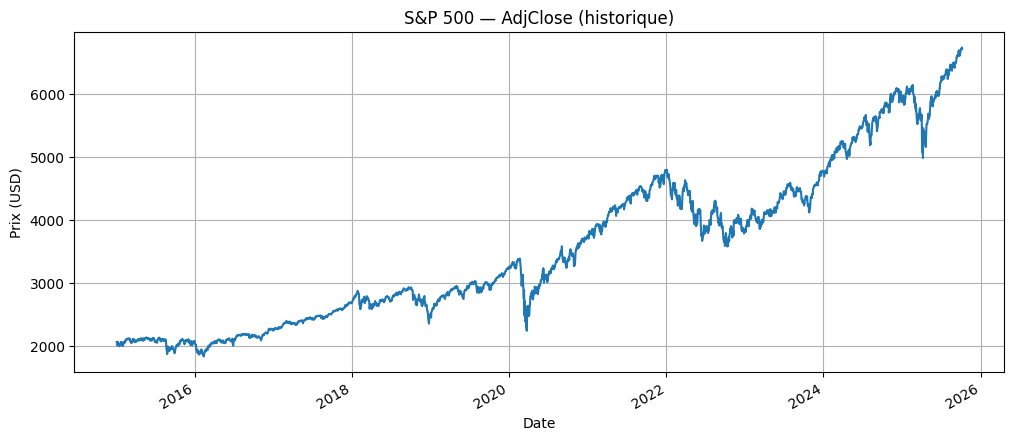

In [37]:
display(df.info())
ax = df['AdjClose'].plot(title='S&P 500 — AdjClose (historique)')
ax.set_xlabel('Date'); ax.set_ylabel('Prix (USD)'); plt.show()

## 3. Feature engineering and target (next-day return)

In [38]:
# Technical indicators on S&P500
df['SMA_5']  = SMAIndicator(close=df['AdjClose'], window=5).sma_indicator()
df['SMA_20'] = SMAIndicator(close=df['AdjClose'], window=20).sma_indicator()
df['EMA_12'] = EMAIndicator(close=df['AdjClose'], window=12).ema_indicator()
df['EMA_26'] = EMAIndicator(close=df['AdjClose'], window=26).ema_indicator()
df['RSI_14'] = RSIIndicator(close=df['AdjClose'], window=14).rsi()
macd = MACD(close=df['AdjClose'], window_slow=26, window_fast=12, window_sign=9)
df['MACD']   = macd.macd()
df['MACD_S'] = macd.macd_signal()
df['MACD_H'] = macd.macd_diff()
bb = BollingerBands(close=df['AdjClose'], window=20, window_dev=2)
df['BB_H'] = bb.bollinger_hband(); df['BB_L'] = bb.bollinger_lband()
df['BB_W'] = df['BB_H'] - df['BB_L']

df['Ret_1d'] = df['AdjClose'].pct_change()
df['Ret_5d'] = df['AdjClose'].pct_change(5)
df['Vol_5']  = df['Ret_1d'].rolling(5).std()
df['Vol_20'] = df['Ret_1d'].rolling(20).std()

df['AdjClose_lag1'] = df['AdjClose'].shift(1)
df['AdjClose_lag3'] = df['AdjClose'].shift(3)
df['Ret_1d_lag1']   = df['Ret_1d'].shift(1)
df['Ret_1d_lag3']   = df['Ret_1d'].shift(3)
df['Ret_mean_3']    = df['Ret_1d'].rolling(3).mean()
df['Ret_std_5']     = df['Ret_1d'].rolling(5).std()

for col in ['VIX','TNX','BRENT','GOLD']:
    df[f'{col}_ret1'] = df[col].pct_change()

# Target = next-day return
df['Target_Ret_t1'] = df['Ret_1d'].shift(-1)
df = df.dropna().copy()
display(df.tail(3))

,Adj Close,Close,High,Low,Open,Volume,AdjClose,VIX,TNX,BRENT,...,AdjClose_lag3,Ret_1d_lag1,Ret_1d_lag3,Ret_mean_3,Ret_std_5,VIX_ret1,TNX_ret1,BRENT_ret1,GOLD_ret1,Target_Ret_t1
Date,,,,,,,,,,,,,,,,,,,,,
2025-10-02,"6,715.3501","6,715.3501","6,731.9399","6,693.2300","6,731.3101","5,416,130,000.0000","6,715.3501",16.6300,4.0880,64.1100,...,"6,661.2100",0.0034,0.0026,0.0027,0.0019,0.0209,-0.0044,-0.0190,-0.0072,0.0001
2025-10-03,"6,715.7900","6,715.7900","6,750.8701","6,705.6699","6,722.1401","5,713,110,000.0000","6,715.7900",16.6500,4.1190,64.5300,...,"6,688.4600",0.0006,0.0041,0.0014,0.0018,0.0012,0.0076,0.0066,0.0107,0.0036
2025-10-06,"6,740.2798","6,740.2798","6,749.5200","6,717.7798","6,733.8599","5,604,460,000.0000","6,740.2798",16.3700,4.1620,65.4700,...,"6,711.2002",0.0001,0.0034,0.0014,0.0019,-0.0168,0.0104,0.0146,0.0174,-0.0038


## 4. Train / test split (chronological 80/20) and baselines

In [39]:
features = [
    'Open','High','Low','Close','Volume',
    'SMA_5','SMA_20','EMA_12','EMA_26',
    'RSI_14','MACD','MACD_S','MACD_H',
    'BB_H','BB_L','BB_W',
    'Ret_1d','Ret_5d','Vol_5','Vol_20',
    'AdjClose','AdjClose_lag1','AdjClose_lag3',
    'Ret_1d_lag1','Ret_1d_lag3','Ret_mean_3','Ret_std_5',
    'VIX','TNX','BRENT','GOLD',
    'VIX_ret1','TNX_ret1','BRENT_ret1','GOLD_ret1'
]
target = 'Target_Ret_t1'
X = df[features]; y = df[target]
split_idx = int(len(df)*0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_test = df.index[split_idx:]
len(X_train), len(X_test)


#Baseline
y_pred_ret_naive0 = np.zeros_like(y_test)
roll = df['Ret_1d'].rolling(5).mean().shift(1)
y_pred_ret_ma5 = roll.iloc[split_idx:].values
y_pred_ret_naive0[:3], y_pred_ret_ma5[:3]

(array([0., 0., 0.]), array([-0.00442769, -0.00424349, -0.00401775]))

## 5. Model training — XGBoost Regressor

In [40]:
model = XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.02,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1,
    reg_lambda=1.0
)
model.fit(X_train, y_train)
y_pred_ret = model.predict(X_test)
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
display(importances.head(20))

,0
VIX,0.0446
Ret_1d_lag3,0.0418
TNX,0.0399
EMA_12,0.0362
AdjClose,0.0356
AdjClose_lag1,0.0349
Ret_1d,0.0327
SMA_5,0.0326
TNX_ret1,0.0324
RSI_14,0.0311


## 6. Evaluation — metrics on reconstructed prices and directional accuracy

In [41]:
def eval_to_price(y_ret_pred, label='Model'):
    price_t = df.loc[dates_test, 'AdjClose'].values
    price_pred = price_t * (1 + y_ret_pred)
    price_true = df.loc[dates_test, 'AdjClose'].shift(-1).dropna().values
    n = min(len(price_pred), len(price_true))
    price_pred, price_true = price_pred[:n], price_true[:n]
    mae  = mean_absolute_error(price_true, price_pred)
    rmse = np.sqrt(mean_squared_error(price_true, price_pred))
    mape = np.mean(np.abs((price_true - price_pred)/price_true))*100
    up_true = (price_true > price_t[:n]).astype(int)
    up_pred = (price_pred > price_t[:n]).astype(int)
    acc_dir = (up_true == up_pred).mean()
    return {'label':label,'MAE':mae,'RMSE':rmse,'MAPE%':mape,'ACC_dir':acc_dir}, price_true, price_pred, n

res_model, y_true_p, y_pred_p, n = eval_to_price(y_pred_ret, 'XGB')
res_naive0, _, y_pred_p0, _ = eval_to_price(y_pred_ret_naive0, 'Naive0')
res_ma5,   _, y_pred_p5, _  = eval_to_price(y_pred_ret_ma5,   'MA5')
pd.DataFrame([res_model, res_naive0, res_ma5])

,label,MAE,RMSE,MAPE%,ACC_dir
0,XGB,53.5771,68.6530,0.9681,0.4457
1,Naive0,35.6827,53.3142,0.6577,0.4232
2,MA5,39.3342,58.3629,0.7255,0.5206


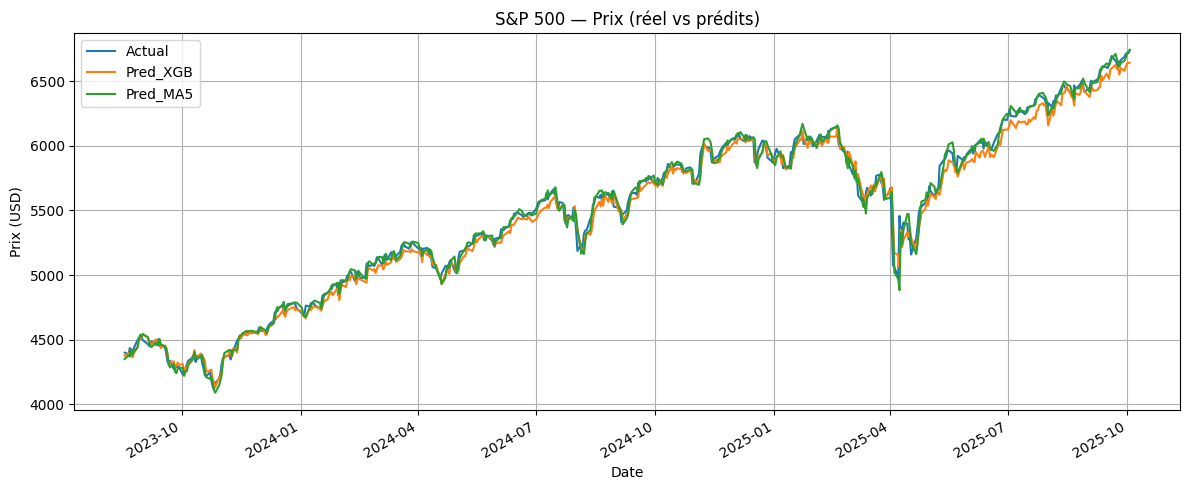

In [42]:
pred_df = pd.DataFrame({
    'Date': dates_test[:n],
    'Actual': y_true_p,
    'Pred_XGB': y_pred_p,
    'Pred_Naive0': y_pred_p0[:n],
    'Pred_MA5': y_pred_p5[:n]
}).set_index('Date')
ax = pred_df[['Actual','Pred_XGB','Pred_MA5']].plot(title='S&P 500 — Prix (réel vs prédits)')
ax.set_xlabel('Date'); ax.set_ylabel('Prix (USD)'); plt.tight_layout(); plt.show()

## 7. Walk-forward (expanding window) cross-validation

In [43]:
def walk_forward_scores(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    out = []
    for i,(tr, te) in enumerate(tscv.split(X)):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]
        m = XGBRegressor(n_estimators=700,max_depth=6,learning_rate=0.03,
                         subsample=0.9,colsample_bytree=0.9,random_state=42,n_jobs=-1)
        m.fit(Xtr, ytr)
        yhat = m.predict(Xte)
        price_t = df.iloc[te]['AdjClose'].values
        price_true = df.iloc[te]['AdjClose'].shift(-1).dropna().values
        n = min(len(price_true), len(yhat), len(price_t))
        price_pred = price_t[:n]*(1+yhat[:n])
        mae  = mean_absolute_error(price_true[:n], price_pred[:n])
        rmse = np.sqrt(mean_squared_error(price_true[:n], price_pred[:n]))
        mape = np.mean(np.abs((price_true[:n]-price_pred[:n])/price_true[:n]))*100
        out.append({'split':i+1,'MAE':mae,'RMSE':rmse,'MAPE%':mape})
    return pd.DataFrame(out)

wf = walk_forward_scores(X, y, n_splits=5)
display(wf)
print('Moyennes :')
display(wf[['MAE','RMSE','MAPE%']].mean())

,split,MAE,RMSE,MAPE%
0,1,18.1883,22.6711,0.7111
1,2,29.8072,48.8075,1.0668
2,3,45.4354,59.1280,1.1467
3,4,55.7642,67.7418,1.3378
4,5,51.2211,66.5261,0.9022


Moyennes :


,0
MAE,40.0832
RMSE,52.9749
MAPE%,1.0329


## 8. Next-day price prediction (live-style demo)

In [44]:
# Use the last available row of features
X_last = X.iloc[[-1]]
pred_return = model.predict(X_last)[0]
last_price = df['AdjClose'].iloc[-1]
pred_price = last_price * (1 + pred_return)

print(f"Last observed price: {last_price:,.2f} USD")
print(f"Predicted next-day return: {pred_return*100:.3f}%")
print(f"Predicted next-day price: {pred_price:,.2f} USD")


Last observed price: 6,740.28 USD
Predicted next-day return: -1.011%
Predicted next-day price: 6,672.14 USD


## 10) Exports

In [45]:
import os
os.makedirs("data", exist_ok=True)

# Prices and exogenous signals
df[['AdjClose','VIX','TNX','BRENT','GOLD']].to_csv("data/df_prices.csv")

# Test-period predictions (actual vs predicted prices)
pred_df[['Actual','Pred_XGB']].to_csv("data/pred_prices_test.csv")

print("Wrote: data/df_prices.csv, data/pred_prices_test.csv")

Wrote: data/df_prices.csv, data/pred_prices_test.csv
